In [2]:
import scipy.io
from scipy import interpolate
import numpy as np

def d3_scale(dat, out_range=(-1, 1), in_range=None):
    if in_range == None:
        domain = [np.min(dat, axis=0), np.max(dat, axis=0)]
    else:
        domain = in_range

    def interp(x):
        return out_range[0] * (1.0 - x) + out_range[1] * x

    def uninterp(x):
        b = 0
        if (domain[1] - domain[0]) != 0:
            b = domain[1] - domain[0]
        else:
            b =  1.0 / domain[1]
        return (x - domain[0]) / b

    return interp(uninterp(dat))

# load the patterns from matlab
pattern_file_names = [
     "nnRawExaStride",
     "nnRawSlowWalk",
     "nnRawWalk",
     "nnRawRunJog",
     "nnRawCartWheel",
     "nnRawWaltz",
     "nnRawCrawl",
     "nnRawStandup",
     "nnRawGetdown",
     "nnRawSitting",
     "nnRawGetSeated",
     "nnRawStandupFromStool",
     "nnRawBox1",
     "nnRawBox2",
     "nnRawBox3",
]

output_dims = 61
pattern_num = 2
pattern_file_names = pattern_file_names[:2]

In [3]:
min_maxs = np.zeros((output_dims, 2))
min_maxs[0,:].shape

(2,)

In [4]:
min_maxs = np.zeros((output_dims, 2))
min_maxs[:, 0] = np.inf
min_maxs[:, 1] = -np.inf
raw_dats = []

# get the actual maximum and minimums for each dimension
for nm in pattern_file_names:
    name = nm[5:]
    raw_dats.append(scipy.io.loadmat("section2.3_demoMotionCapture/nnData/%s.mat" %(nm))["nnRawData"+name].T)
    for o_i in range(output_dims):
        assert raw_dats[-1][o_i].shape != (61,)
        
        min_val = np.min(raw_dats[-1][o_i])
        if min_val < min_maxs[o_i, 0]:
            min_maxs[o_i, 0] = min_val

        max_val = np.max(raw_dats[-1][o_i])
        if max_val > min_maxs[o_i, 1]:
            min_maxs[o_i, 1] = max_val

In [6]:
assert np.all(min_maxs[:, 0] != np.inf)
assert np.all(min_maxs[:, 1] != -np.inf)

In [7]:
function_list = []

for n_i, nm in enumerate(pattern_file_names):
    # make each pattern values normalised between -1, 1
    # and temporally squash them between -1 and 1 too
    function_list.append([])
    raw_dat = raw_dats[n_i]
    xv = np.linspace(-1, 1, raw_dat.shape[1])
    assert raw_dat.shape[0] == output_dims
    normed_data = np.zeros_like(raw_dat)

    for o_i in range(output_dims):
        assert min_maxs[o_i][0] <= np.min(raw_dat[o_i, :]) 
        assert min_maxs[o_i][1] >= np.max(raw_dat[o_i, :]) 
        normed_data[o_i, :] = d3_scale(raw_dat[o_i, :], in_range=min_maxs[o_i])
        assert np.max(normed_data) <= 1.0
        assert np.min(normed_data) >= -1.0
        function_list[-1].append(interpolate.interp1d(xv, normed_data[o_i, :]))

c:\Users\Sean Aubin\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
print(raw_dats[0][0].shape)
print(min_maxs[0])

(291,)
[ 789.22785097  985.73773527]


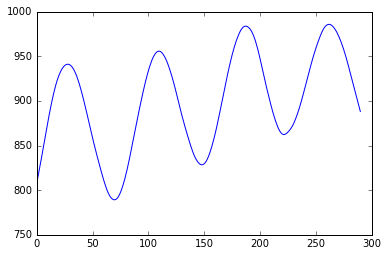

In [10]:
plt.plot(raw_dats[0][0])
#plt.plot(raw_dats[1][0])
plt.savefig("good")

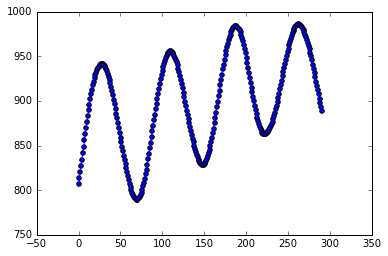

In [11]:
# can approx? yes!
raw_dat = raw_dats[0][0]
x_max = raw_dat.shape[0]
xv = np.linspace(0, x_max, x_max)
plt.scatter(xv, raw_dat)

x_new = np.linspace(-np.pi, np.pi, x_max)
f_approx = interpolate.interp1d(x_new, d3_scale(raw_dat))
plt.plot(d3_scale(f_approx(x_new), in_range=(-1, 1), out_range=min_maxs[0]))

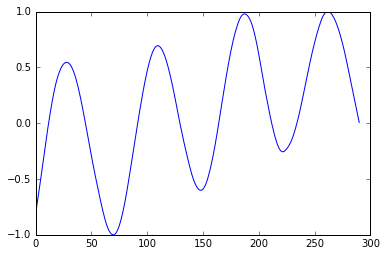

In [12]:
xv = np.linspace(-1, 1, raw_dat.shape[0])

plt.plot(function_list[0][0](xv))

In [13]:
af = scipy.io.loadmat("section2.3_demoMotionCapture/nnData/%s.mat" %(pattern_file_names[0]))

In [14]:
tmp = af['nnRawDataExaStride'].T
tmp[0].shape

(291,)

In [54]:
pat_out = scipy.io.loadmat("pattern_out.mat")
reg_out = pat_out["reg_out"]
#ideal_out = pat_out["ideal_out"]
compr = pat_out["compressed"]
#print(ideal_out.T.shape)
print(np.min(reg_out))
print(np.max(reg_out))
print(reg_out.T.shape)
print(np.min(reg_out))
print(np.max(reg_out))

-1.51095341734e-15
951.51482345
(5, 2000)
-1.51095341734e-15
951.51482345


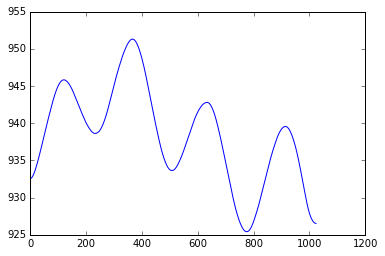

In [55]:
import nengo

plt_val = reg_out[:, 0][975:]
#plt.plot(plt_val)
plt.plot(nengo.Lowpass(0.01).filt(plt_val, dt=0.001))

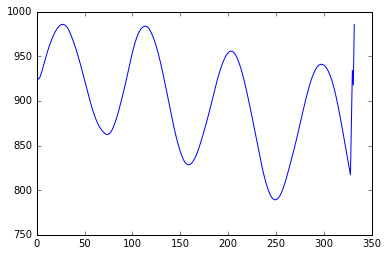

In [18]:
plt.plot(ideal_out[0])

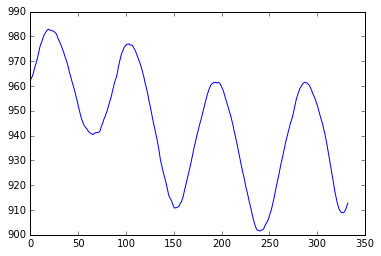

In [19]:
plt.plot(compr[0])

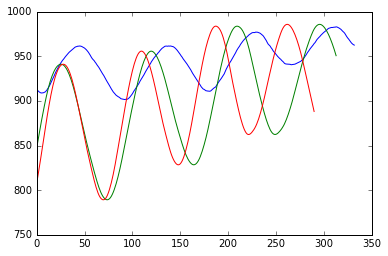

In [28]:
plt.plot(compr[0][::-1])
plt.plot(ideal_out[0][::-1][9:-10])
plt.plot(raw_dats[0][0])

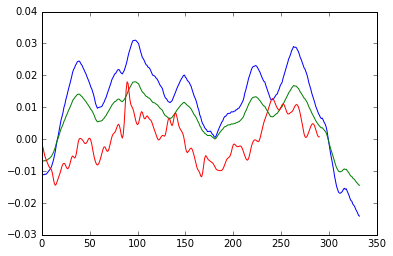

In [62]:
plt.plot(compr[1]*10-0.1)
plt.plot(d3_scale(compr[1], in_range=(np.min(compr[1]), np.max(compr[1])), out_range=(np.min(raw_dats[0][1]), np.max(raw_dats[0][1]))))
plt.plot(raw_dats[0][1][::-1])

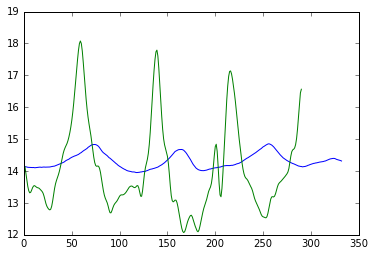

In [44]:
plt.plot(compr[2]-1)
plt.plot(raw_dats[0][2])

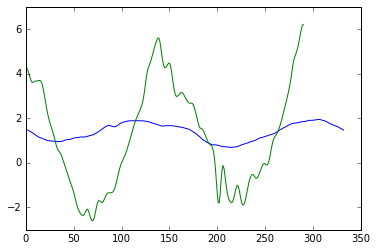

In [47]:
plt.plot(compr[3]-1)
plt.plot(raw_dats[0][3])

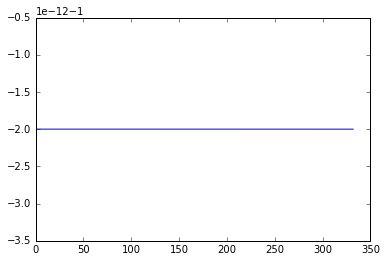

In [52]:
# it's basically zero, so whatevs
plt.plot(compr[4]-1)
#plt.plot(raw_dats[0][4])

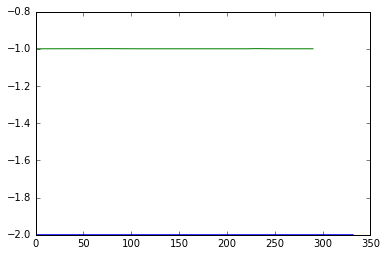

In [53]:
plt.plot(compr[5]-1)
plt.plot(raw_dats[0][5])

In [63]:
fin_out = scipy.io.loadmat("final_pattern.mat")["final_out"]

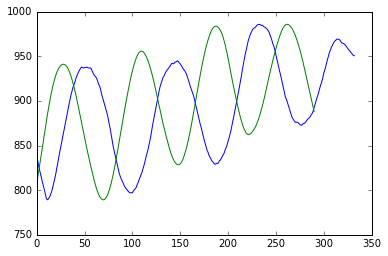

In [67]:
plt.plot(fin_out[0][::-1])
plt.plot(raw_dats[0][0])
# This looks important for comparison:
#http://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.coherence.html